# Check the correct working of the star cluster simulation code 

Use the star cluster simulation code in the module `agabpylib.simulation.starclusters` and check that it produces reasonable results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

from scipy.stats import norm

from agabpylib.simulation.starclusters.cluster import StarCluster, StarAPs
from agabpylib.simulation.imf import MultiPartPowerLaw as mppl
from agabpylib.simulation.starclusters.spacedistributions import PlummerSphere, ConstantDensitySphere, \
    SphericalShell, TruncatedPlummerSphere
from agabpylib.simulation.starclusters.kinematics import LinearVelocityField
from agabpylib.simulation.starclusters.observables import GaiaSurvey
from agabpylib.plotting.plotstyles import useagab, apply_tufte

## Simulate the cluster

The next code block generates a simulated cluster according to the various input parameters

In [3]:
# Kroupa type IMF
imf = mppl(np.array([0.3,1.3,2.3]), np.array([0.1,0.5]))

# Astrophysical parameters of the cluster stars
age = 625*u.Myr
isodir = "/home/brown/Stars/Modelgrids"
feh = 0.0
afeh = 0.0
vvcrit = 0.0

# Number of stars and core radius for Plummer distribution
nstars = 5000
rcore = 6*u.pc
rtrunc = 3*rcore

# Kinematic parameters
v=np.array([-6.30, 45.44, 5.32])*u.km/u.s
s=np.array([1.69, 1.95, 1.06])*u.km/u.s
omega = np.array([0.0,0.0,0.0])*u.km/u.s/u.pc
kappa = 0.0*u.km/u.s/u.pc

aps = StarAPs(age, feh, afeh, vvcrit, isodir, imf, iso="mist")
#pos = PlummerSphere(rcore)
pos = TruncatedPlummerSphere(rcore, rtrunc)
#pos = ConstantDensitySphere(rcore)
#pos = SphericalShell(rcore)
kin = LinearVelocityField(v, s, omega, kappa)

distance_c = 450.0*u.pc
ra_c = 60.5*u.deg
dec_c = 15.9*u.deg
obs_interval = 22
survey = GaiaSurvey(obs_interval, distance_c, ra_c, dec_c, rvslim=12.0)

cluster = StarCluster(nstars, aps, pos, kin, survey)

astrophoto_observed = np.logical_not(np.isnan(cluster.star_table['parallax_obs']))
rvs_observed = np.logical_not(np.isnan(cluster.star_table['radial_velocity_obs']))

cluster.write_star_table('cluster.vot', 'votable', overwrite=True)

Reading in: /home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd


In [19]:
print(cluster.getinfo())

Simulated cluster parameters
Number of stars: 5000

Astrophysical parameters
------------------------
Isochrone models: mist
Age, log(Age) specified: 625.0 Myr, 8.795880017344075
log(Age) loaded: 8.8
[M/H]: 0.0
[alpha/Fe]: 0.0
[v/vcrit]: 0.0
Isochrone file: /home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd

Initial Mass Function
---------------------
Multi-part powerlaw: slopes [0.3 1.3 2.3]; masses of break-points [0.1 0.5]

Space distribution
------------------
Truncated Plummer density distribution: core radius 6.0 pc, truncation radius 18.0 pc

Kinematics
------------------
Linear velocity field:
 v = [-6.3  45.44  5.32] km / s
 s = [1.69 1.95 1.06] km / s
 omega = [0. 0. 0.] km / (pc s)
 kappa = 0.0 km / (pc s)


Simulated observations
----------------------
Gaia data for 22 months of data collection
 Cluster distance: 45.0 pc
 Cluster position: (60.5 deg, 15.9 deg)
 RVS Survey limit: Grvs=12.0
 Number of stars with

In [20]:
print(cluster.getmeta())

{'timestamp': '2019-09-29-13:01:45', 'n_stars': 5000, 'ID': 'Simulated_cluster', 'age': <Quantity 625. Myr>, 'logage': 8.795880017344075, 'logageloaded': 8.8, 'metallicity': 0.0, 'alpha_over_fe': 0.0, 'vvcrit': 0.0, 'stellarmodels': 'mist', 'isochronefile': '/home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd', 'IMF': 'Multi-part powerlaw', 'IMF_slopes': array([0.3, 1.3, 2.3]), 'IMF_break_points': array([0.1, 0.5]), 'space_distribution': 'Truncated Plummer sphere', 'plummer_core_radius': <Quantity 6. pc>, 'plummer_truncation_radius': <Quantity 18. pc>, 'kinematics': 'Linear velocity field', 'mean_velocity': <Quantity [-6.3 , 45.44,  5.32] km / s>, 'velocity_dispersion': <Quantity [1.69, 1.95, 1.06] km / s>, 'rotation_rate': <Quantity [0., 0., 0.] km / (pc s)>, 'expansion_rate': <Quantity 0. km / (pc s)>, 'simulated_survey': 'Gaia', 'data_collection_interval': 22, 'cluster_distance': <Quantity 45. pc>, 'cluster_ra': <Quanti

In [21]:
cluster.star_table[0:10].show_in_notebook()

idx,source_id,initial_mass,mass,log_L,log_Teff,log_g,Gabs,Gabs_BPb,Gabs_BPf,Gabs_RP,Vabs,Iabs,x,y,z,v_x,v_y,v_z,G,GBP,GRP,GRVS,GminV,VminI,ra,dec,parallax,pmra,pmdec,radial_velocity,G_obs,G_obs_error,GBP_obs,GBP_obs_error,GRP_obs,GRP_obs_error,ra_obs,ra_error,dec_obs,dec_error,parallax_obs,parallax_error,pmra_obs,pmra_error,pmdec_obs,pmdec_error,radial_velocity_obs,radial_velocity_error
,,solMass,solMass,,,,,,,,,,pc,pc,pc,km / s,km / s,km / s,,,,,,,deg,deg,mas,mas / yr,mas / yr,km / s,,,,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s
0,0,0.1694241065593966,0.16942373623689191,-2.4728777843843806,3.5005207069853395,5.092379302555077,12.011355606154524,13.56567542096911,13.608964011694058,10.82778075604535,13.343143384822405,10.548579576296401,-8.4928581889477,-2.625538411579355,1.5124275794218718,-6.397085464299771,44.40982544815325,5.236390746290415,15.010618613859945,16.60822701939948,13.82704376375077,13.132258631191752,-1.3317877786678824,2.7945638085260054,69.90740588811373,20.351466408583082,25.12739104159519,112.71339836750371,-46.80948252436372,38.86414687780476,15.010311131236667,0.00040406179214783956,16.60844331828515,0.004010596427397289,13.827250319145122,0.0014931454360074471,69.90740590217112,0.035730695755060916,20.351466408090587,0.03173539559439336,25.204511578151386,0.04540113818940396,112.83625712275605,0.06884463499993254,-46.762057880409564,0.06141535784166643,nan,nan
1,1,0.6348489585741955,0.6348457066861213,-1.0241220415361407,3.61941949253138,4.696071213903075,7.5963254828314755,8.319282044059731,8.366063658908402,6.788979209156801,8.09394302313002,6.6453553122447575,3.9725068149442224,3.7711621218108116,2.150650125363292,-6.902668571606523,45.37733910824716,6.144994254944474,11.119498569596725,11.889236745673653,10.31215229592205,9.869699537065403,-0.49761754029854544,1.4485877108852634,58.61059577223962,16.60809782306608,19.74082882218546,122.96112666262705,-17.30477064756437,35.43134961343613,11.11955977490546,0.00025062135938730553,11.889891492127326,0.0012051753714574021,10.31273345347358,0.0011891061505866806,58.610595768449066,0.008420435889316092,16.6080978233927,0.0074788877847928184,19.748956076312165,0.010699410278673561,122.99000175662168,0.016224196677115908,-17.33240752804622,0.014473384086060234,36.509358230801936,0.6378568053154863
2,2,0.1441609222986784,0.1441606175795659,-2.617726521291378,3.4910475867583846,5.130234910922481,12.471098360285966,14.16953274630034,14.212612433882912,11.249459631212495,13.948830342009401,10.966750599818848,0.9366689411812134,-5.228736988807407,-0.538238755105979,-5.548137911188583,46.267400375630736,5.915847717352141,15.538404161603545,17.27991823520049,14.316765432530074,13.606891692260682,-1.4777319817234371,2.982079742190555,55.55598452811166,16.685078180237394,24.352235766373845,157.93635853989892,-22.53747377628828,35.241898031754694,15.537864148792174,0.00048274726002027295,17.285464658667387,0.006558727556694908,14.318068220152094,0.001684366234203223,55.555984534343374,0.04635665718063214,16.685078170906763,0.04117319360770249,24.33512322778441,0.058902995146927734,157.86714847522623,0.08931835991370494,-22.4684087550674,0.07967968798057132,nan,nan
3,3,0.8567038631753421,0.8566940901366001,-0.4266048792063095,3.711663645868634,4.596661292775525,5.757627737443199,6.1836351871163755,6.219697416531629,5.186318988325876,5.9701057215002695,5.090960572498303,8.717474837059834,-2.7041438568596825,0.5120267733343625,-6.0553168004304725,43.649389256147835,4.989485955213891,9.156760127257305,9.582767576930483,8.585451378139982,8.322926677927143,-0.2124779840570703,0.8791451490019657,49.34196805873903,15.567701879125003,20.901310743583437,145.64688777579772,-13.322063076952354,29.436660756612802,9.156714816486819,0.00025062135938730553,9.579853252660046,0.0011953869236285466,8.586216582650316,0.001191176860467328,49.34196805758673,0.008353725481692956,15.56770187830574,0.007419636736598953,20.879384675214208,0.010614644830613668

In [22]:
cluster.star_table.info

<QTable length=5000>
         name          dtype    unit    class   n_bad
--------------------- ------- -------- -------- -----
            source_id   int64            Column     0
         initial_mass float64  solMass Quantity     0
                 mass float64  solMass Quantity     0
                log_L float64            Column     0
             log_Teff float64            Column     0
                log_g float64            Column     0
                 Gabs float64            Column     0
             Gabs_BPb float64            Column     0
             Gabs_BPf float64            Column     0
              Gabs_RP float64            Column     0
                 Vabs float64            Column     0
                 Iabs float64            Column     0
                    x float64       pc Quantity     0
                    y float64       pc Quantity     0
                    z float64       pc Quantity     0
                  v_x float64   km / s Quantity     0
       

## Space distribution of stars

Check that the spatial distribution of the stars in the cluster is statistically correct.

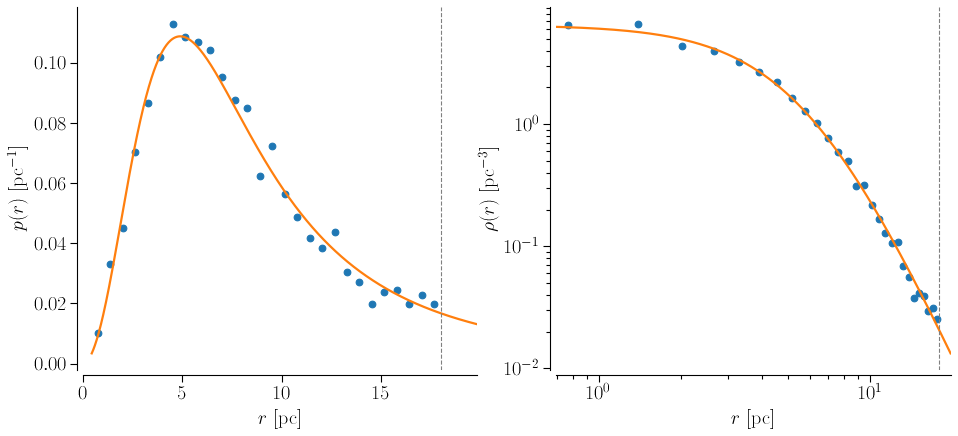

In [23]:
r = np.sqrt(cluster.star_table['x']**2 + cluster.star_table['y']**2 + cluster.star_table['z']**2)
rmaxplot = 0.0
if isinstance(pos, PlummerSphere):
    fd = lambda x : 3/(4*np.pi*rcore.value**3)*(1+(x/rcore.value)**2)**(-5/2)
    fn = lambda x : 4*np.pi*x**2*fd(x)
    rplotmax = 5*rcore.value
elif isinstance(pos, ConstantDensitySphere):
    fd = lambda x : np.repeat(3/(4*np.pi*rcore.value**3), x.size)
    fn = lambda x : 4*np.pi*x**2*fd(x)
    rplotmax = rcore.value
elif isinstance(pos, TruncatedPlummerSphere):
    c = ((rtrunc.value/rcore.value)**(-2)+1)**(1.5)
    fd = lambda x : 3*c/(4*np.pi*rcore.value**3)*(1+(x/rcore.value)**2)**(-5/2)
    fn = lambda x : 4*np.pi*x**2*fd(x)
    rplotmax = rtrunc.value*1.1
else:
    pass
    
useagab(usetex=False, fontfam='sans', sroncolours=False)

fig, (axA, axB) = plt.subplots(1, 2, figsize=(14,6))
apply_tufte(axA)
apply_tufte(axB)

rr = np.linspace(r.min().value,rplotmax,1000)
h, bins = np.histogram(r.value, bins='auto', density=False)
dbin = (bins[1:]-bins[0:-1])
xbin = dbin/2 +  bins[0:-1]

axA.plot(xbin, h/nstars/dbin, 'o')
axA.plot(rr, fn(rr))
axA.set_xlim(0,rplotmax)
axA.set_xlabel(r'$r$ [pc]')
axA.set_ylabel(r'$p(r)$ [pc$^{-1}$]')
if isinstance(pos, TruncatedPlummerSphere):
    axA.axvline(x=rtrunc.value, c='gray', ls='--', lw=1)

dens = h/(4*np.pi/3*(bins[1:]**3-bins[0:-1]**3))
axB.loglog(xbin, dens, 'o')
axB.loglog(rr, nstars*fd(rr))
axB.set_xlim(0.9*xbin.min(),rplotmax)
axB.set_xlabel(r'$r$ [pc]')
axB.set_ylabel(r'$\rho(r)$ [pc$^{-3}$]')
if isinstance(pos, TruncatedPlummerSphere):
    axB.axvline(x=rtrunc.value, c='gray', ls='--', lw=1)

plt.show()

## Initial mass function

Check that the initial mass distribution follows the requested IMF.

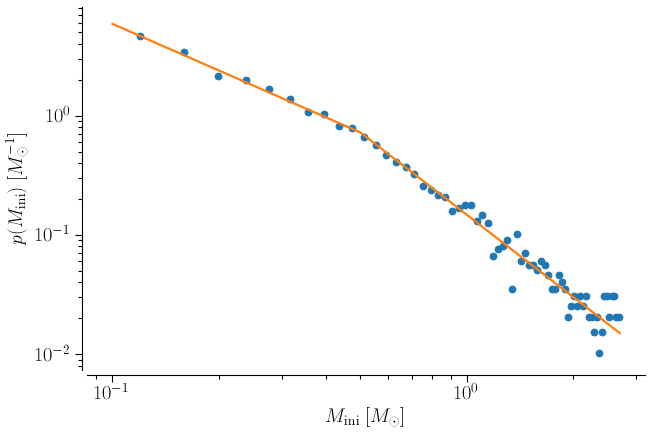

In [24]:
fig, aximf = plt.subplots(1, 1, figsize=(9,6))
apply_tufte(aximf)

min_mass = cluster.star_table['initial_mass'].min().value
max_mass = cluster.star_table['initial_mass'].max().value
mm = np.linspace(min_mass, max_mass, 1000)
h_imf, bins_imf = np.histogram(cluster.star_table['initial_mass'].value, bins='auto', density=True)
dbin_imf = (bins_imf[1:]-bins_imf[0:-1])
xbin_imf = dbin_imf/2 +  bins_imf[0:-1]

aximf.loglog(xbin_imf, h_imf, 'o')
aximf.loglog(mm, np.exp(imf.lnpdf(mm, min_mass, max_mass)))
aximf.set_xlabel(r'$M_\mathrm{ini}$ [$M_\odot$]')
aximf.set_ylabel(r'$p(M_\mathrm{ini})$ [$M_\odot^{-1}$]')

plt.show()

## Cluster Hertzsprung-Russell and colour-magnitude diagrams

Check that the HRD and CMD look reasonable.

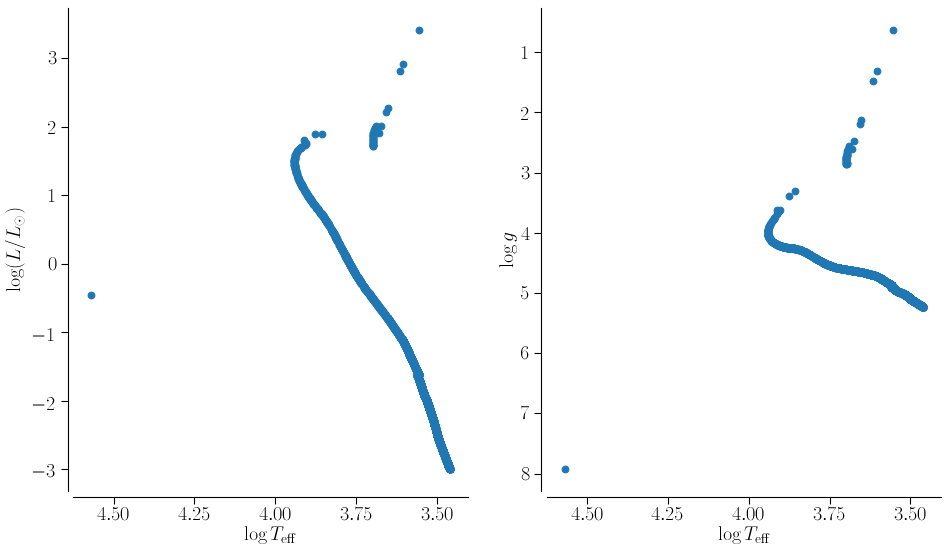

In [25]:
fig, (axtl, axtg) = plt.subplots(1, 2, figsize=(14,8))
apply_tufte(axtl)
apply_tufte(axtg)

axtl.plot(cluster.star_table['log_Teff'], cluster.star_table['log_L'], 'o')
axtl.invert_xaxis()
axtl.set_xlabel(r'$\log T_\mathrm{eff}$')
axtl.set_ylabel(r'$\log(L/L_\odot)$')

axtg.plot(cluster.star_table['log_Teff'], cluster.star_table['log_g'], 'o')
axtg.invert_xaxis()
axtg.invert_yaxis()
axtg.set_xlabel(r'$\log T_\mathrm{eff}$')
axtg.set_ylabel(r'$\log g$')

plt.show()

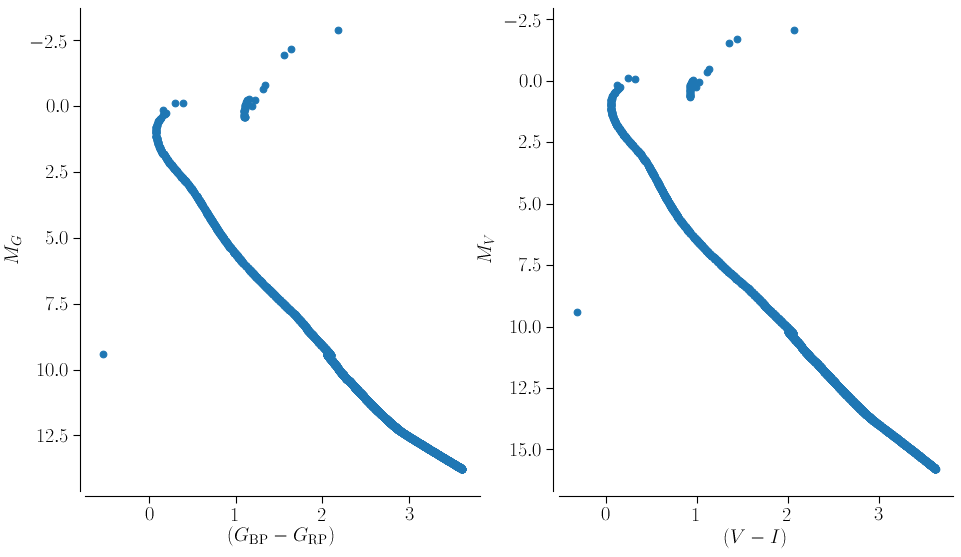

In [26]:
fig, (axbprp, axvmini) = plt.subplots(1, 2, figsize=(14,8))
apply_tufte(axbprp)
apply_tufte(axvmini)

axbprp.plot(cluster.star_table['Gabs_BPf']-cluster.star_table['Gabs_RP'], cluster.star_table['Gabs'], 'o')
axbprp.invert_yaxis()
axbprp.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axbprp.set_ylabel(r'$M_G$')

axvmini.plot(cluster.star_table['Vabs']-cluster.star_table['Iabs'], cluster.star_table['Vabs'], 'o')
axvmini.invert_yaxis()
axvmini.set_xlabel(r'$(V-I)$')
axvmini.set_ylabel(r'$M_V$')

plt.show()

## Kinematics

Inspect the simulated knematics for correctness.

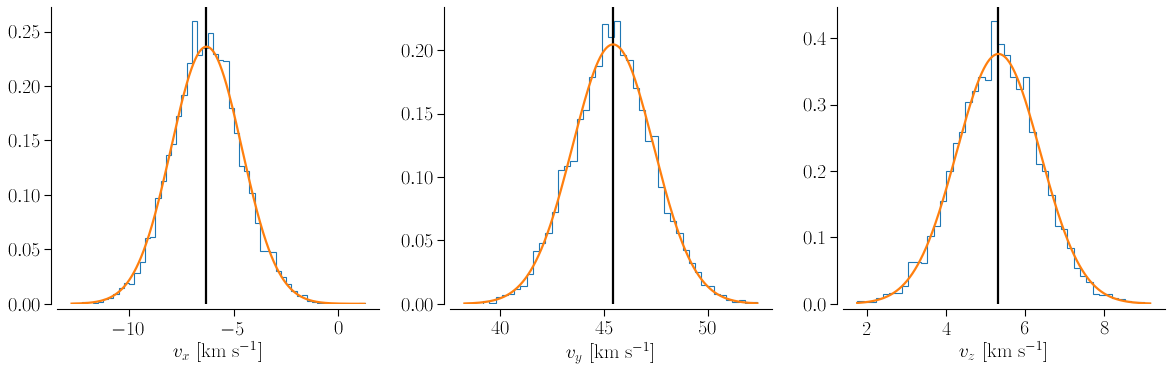

In [27]:
fig, (axvx, axvy, axvz) = plt.subplots(1, 3, figsize=(15,5))
apply_tufte(axvx)
apply_tufte(axvy)
apply_tufte(axvz)

axvx.hist(cluster.star_table['v_x'].value, bins='auto', histtype='step', density=True)
axvx.axvline(x=cluster.getmeta()['mean_velocity'][0].value, color='k')
xx = np.linspace(cluster.star_table['v_x'].min(), cluster.star_table['v_x'].max(), 1000)
axvx.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][0], 
          scale=cluster.getmeta()['velocity_dispersion'][0]))
axvx.set_xlabel(r'$v_x$ [km s$^{-1}$]')

axvy.hist(cluster.star_table['v_y'].value, bins='auto', histtype='step', density=True)
axvy.axvline(x=cluster.getmeta()['mean_velocity'][1].value, color='k')
xx = np.linspace(cluster.star_table['v_y'].min(), cluster.star_table['v_y'].max(), 1000)
axvy.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][1], 
          scale=cluster.getmeta()['velocity_dispersion'][1]))
axvy.set_xlabel(r'$v_y$ [km s$^{-1}$]')

axvz.hist(cluster.star_table['v_z'].value, bins='auto', histtype='step', density=True)
axvz.axvline(x=cluster.getmeta()['mean_velocity'][2].value, color='k')
xx = np.linspace(cluster.star_table['v_z'].min(), cluster.star_table['v_z'].max(), 1000)
axvz.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][2], 
          scale=cluster.getmeta()['velocity_dispersion'][2]))
axvz.set_xlabel(r'$v_z$ [km s$^{-1}$]')

plt.tight_layout()

plt.show()

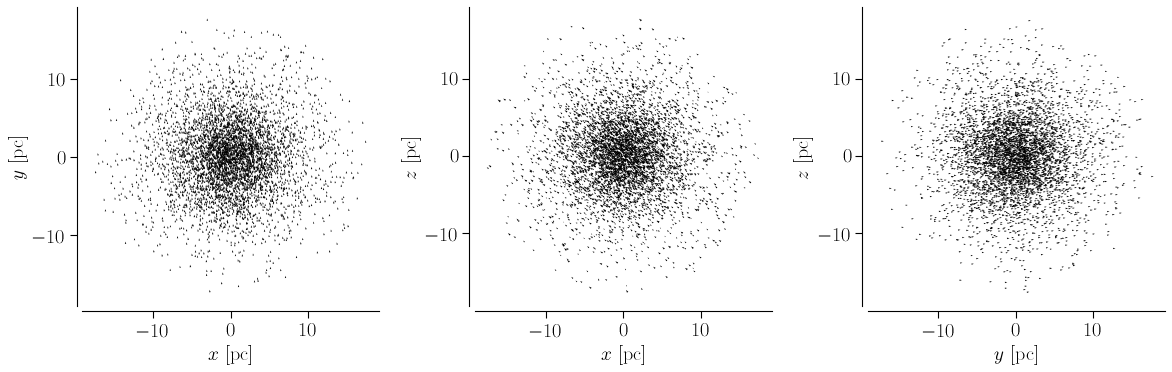

In [28]:
fig, (axxyq, axxzq, axyzq) = plt.subplots(1, 3, figsize=(15,5))
apply_tufte(axxyq)
apply_tufte(axxzq)
apply_tufte(axyzq)

axxyq.quiver(cluster.star_table['x'].value, cluster.star_table['y'].value, cluster.star_table['v_x'].value, 
             cluster.star_table['v_y'].value)
axxyq.set_xlabel(r'$x$ [pc]')
axxyq.set_ylabel(r'$y$ [pc]')

axxzq.quiver(cluster.star_table['x'].value, cluster.star_table['z'].value, cluster.star_table['v_x'].value, 
             cluster.star_table['v_z'].value)
axxzq.set_xlabel(r'$x$ [pc]')
axxzq.set_ylabel(r'$z$ [pc]')

axyzq.quiver(cluster.star_table['y'].value, cluster.star_table['z'].value, cluster.star_table['v_y'].value, 
             cluster.star_table['v_z'].value)
axyzq.set_xlabel(r'$y$ [pc]')
axyzq.set_ylabel(r'$z$ [pc]')

plt.tight_layout()

plt.show()

## Simulated observations

### Observational uncertainties

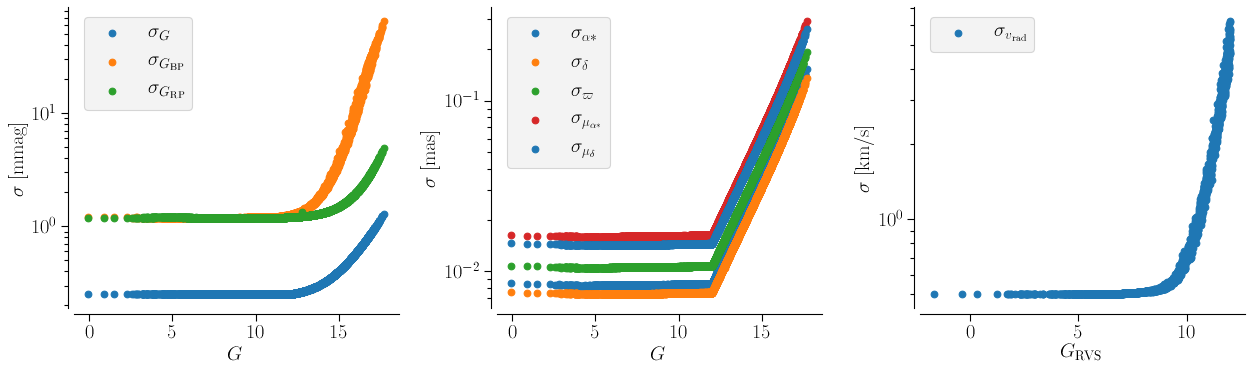

In [29]:
fig, (axphot, axastrom, axvrad) = plt.subplots(1, 3, figsize=(16,5))
apply_tufte(axphot)
apply_tufte(axastrom)
apply_tufte(axvrad)

axphot.semilogy(cluster.star_table['G'], cluster.star_table['G_obs_error']*1000, 'o', label=r'$\sigma_G$')
axphot.semilogy(cluster.star_table['G'], cluster.star_table['GBP_obs_error']*1000, 'o', 
                label=r'$\sigma_{G_\mathrm{BP}}$')
axphot.semilogy(cluster.star_table['G'], cluster.star_table['GRP_obs_error']*1000, 'o', 
                label=r'$\sigma_{G_\mathrm{RP}}$')
axphot.set_xlabel(r'$G$')
axphot.set_ylabel(r'$\sigma$ [mmag]')
axphot.legend()

axastrom.semilogy(cluster.star_table['G'], cluster.star_table['ra_error'], 'o', label=r'$\sigma_{\alpha*}$')
axastrom.semilogy(cluster.star_table['G'], cluster.star_table['dec_error'], 'o', label=r'$\sigma_\delta$')
axastrom.semilogy(cluster.star_table['G'], cluster.star_table['parallax_error'], 'o', label=r'$\sigma_\varpi$')
axastrom.semilogy(cluster.star_table['G'], cluster.star_table['pmra_error'], 'o', 
                 label=r'$\sigma_{\mu_{\alpha*}}$')
axastrom.semilogy(cluster.star_table['G'], cluster.star_table['pmdec_error'], 'o', label=r'$\sigma_{\mu_\delta}$')
axastrom.set_xlabel(r'$G$')
axastrom.set_ylabel(r'$\sigma$ [mas]')
axastrom.legend()

axvrad.semilogy(cluster.star_table['GRVS'], cluster.star_table['radial_velocity_error'], 'o', 
               label=r'$\sigma_{v_\mathrm{rad}}$')
axvrad.set_xlabel(r'$G_\mathrm{RVS}$')
axvrad.set_ylabel(r'$\sigma$ [km/s]')
axvrad.legend()

plt.tight_layout()
plt.show()

### Colour-magnitude diagrams

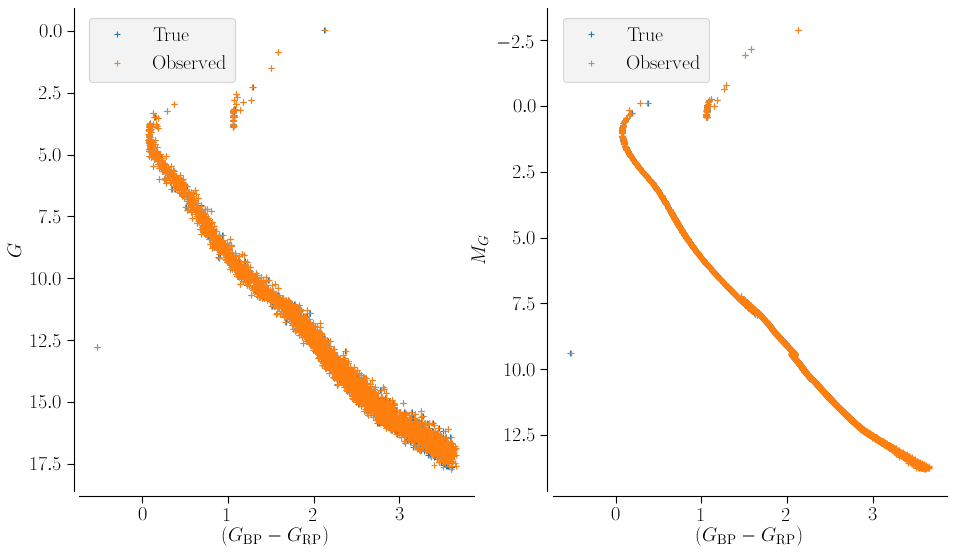

In [30]:
fig, (axcmd, axhrd) = plt.subplots(1, 2, figsize=(14,8))
apply_tufte(axcmd)
apply_tufte(axhrd)

axhrd.plot(cluster.star_table['GBP']-cluster.star_table['GRP'], cluster.star_table['Gabs'], '+', 
          label='True')
valid = cluster.star_table['parallax_obs'][astrophoto_observed] > 0
axhrd.plot(cluster.star_table['GBP_obs'][astrophoto_observed][valid] -
           cluster.star_table['GRP_obs'][astrophoto_observed][valid], 
           cluster.star_table['G_obs'][astrophoto_observed][valid] + 
           5*np.log10(cluster.star_table['parallax_obs'][astrophoto_observed][valid].value)-10.0, '+',
           label='Observed')
axhrd.invert_yaxis()
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$M_G$')
axhrd.legend()

axcmd.plot(cluster.star_table['GBP']-cluster.star_table['GRP'], cluster.star_table['G'], '+', label='True')
axcmd.plot(cluster.star_table['GBP_obs'][astrophoto_observed]-cluster.star_table['GRP_obs'][astrophoto_observed], 
           cluster.star_table['G_obs'][astrophoto_observed], '+', label='Observed')
axcmd.invert_yaxis()
axcmd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axcmd.set_ylabel(r'$G$')
axcmd.legend()

plt.show()

### Astrometry and radial velocities

/home/brown/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:393: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/home/brown/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:394: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/home/brown/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/brown/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


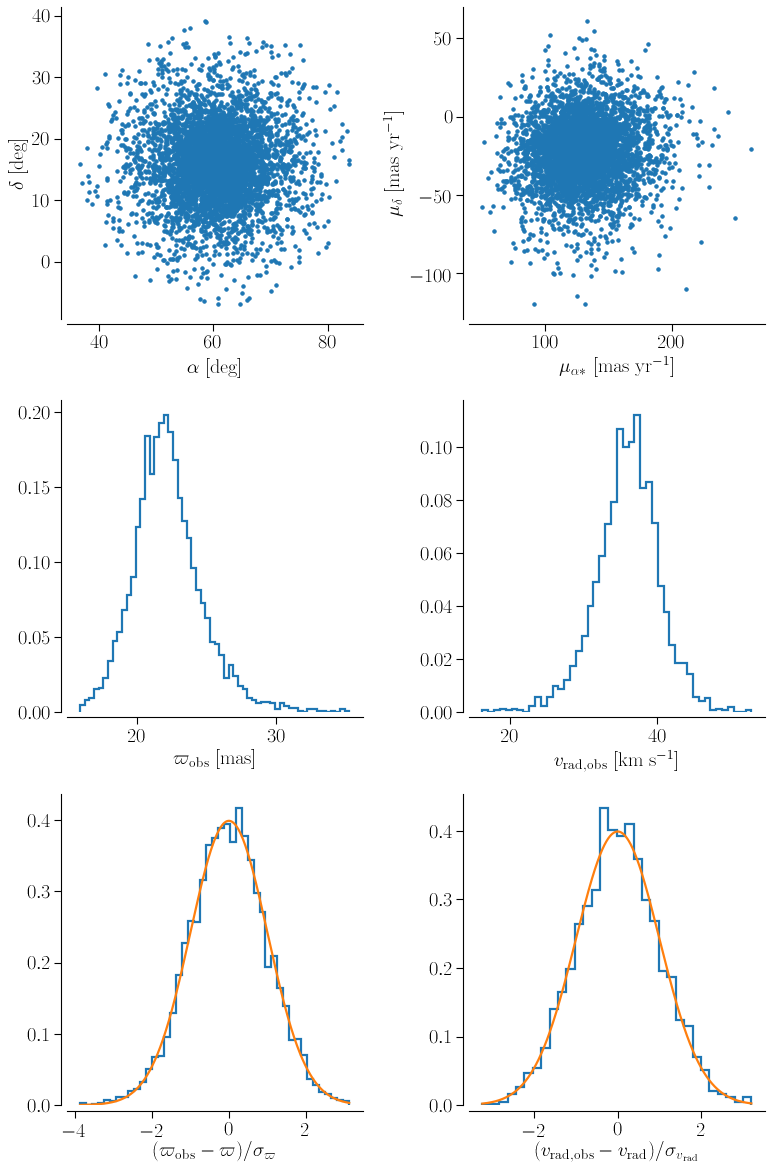

In [31]:
fig, axx = plt.subplots(3, 2, figsize=(10,15))
axx = [a for aa in axx for a in aa]
for a in axx:
    apply_tufte(a)
    
axx[0].plot(cluster.star_table['ra_obs'], cluster.star_table['dec_obs'], '.')
axx[0].set_xlabel(r'$\alpha$ [deg]')
axx[0].set_ylabel(r'$\delta$ [deg]')
    
axx[1].plot(cluster.star_table['pmra_obs'], cluster.star_table['pmdec_obs'], '.')
axx[1].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
axx[1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

axx[2].hist(cluster.star_table['parallax_obs'].value, bins='auto', histtype='step', density=True, lw=2)
axx[2].set_xlabel(r'$\varpi_\mathrm{obs}$ [mas]')

axx[3].hist(cluster.star_table['radial_velocity_obs'].value, bins='auto', histtype='step', density=True, lw=2)
axx[3].set_xlabel(r'$v_\mathrm{rad,obs}$ [km s$^{-1}$]')

plxdiff = (cluster.star_table['parallax_obs'][astrophoto_observed] - 
           cluster.star_table['parallax'][astrophoto_observed])/ \
           cluster.star_table['parallax_error'][astrophoto_observed]
axx[4].hist(plxdiff, bins='auto', histtype='step', density=True, lw=2)
xx = np.linspace(plxdiff.min(), plxdiff.max(), 1000)
axx[4].plot(xx, norm.pdf(xx, loc=0, scale=1))
axx[4].set_xlabel(r'$(\varpi_\mathrm{obs}-\varpi)/\sigma_\varpi$')

vrdiff = (cluster.star_table['radial_velocity_obs'][rvs_observed] - 
          cluster.star_table['radial_velocity'][rvs_observed]) / \
          cluster.star_table['radial_velocity_error'][rvs_observed]
axx[5].hist(vrdiff, bins='auto', histtype='step', density=True, lw=2)
xx = np.linspace(vrdiff.min(), vrdiff.max(), 1000)
axx[5].plot(xx, norm.pdf(xx, loc=0, scale=1))
axx[5].set_xlabel(r'$(v_\mathrm{rad,obs}-v_\mathrm{rad})/\sigma_{v_\mathrm{rad}}$')

plt.tight_layout()

### Proper motions and radial velocity as a function of sky position

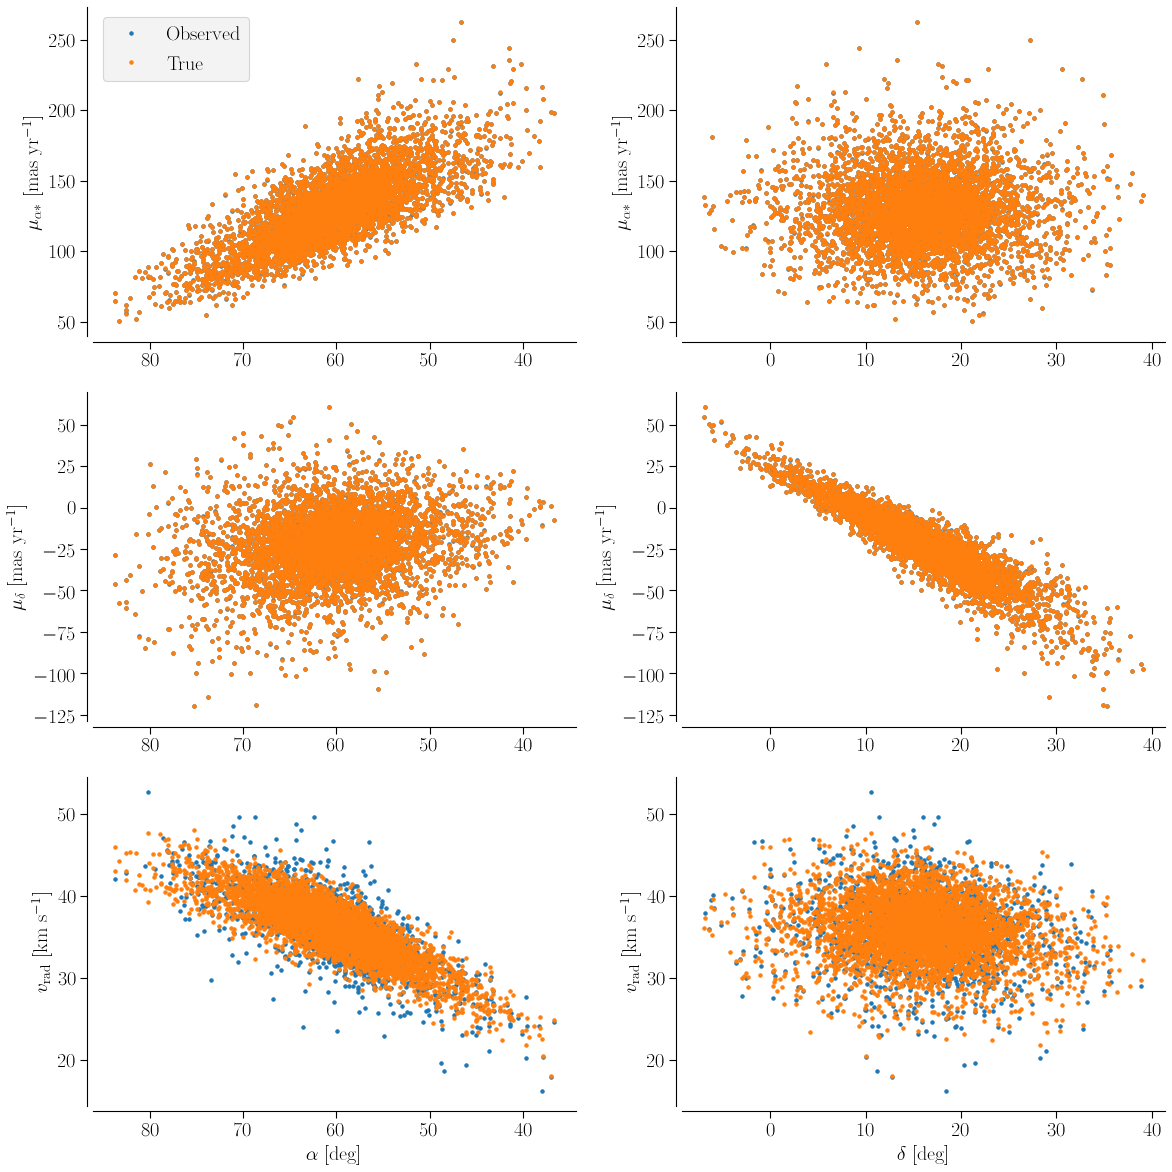

In [32]:
fig, axxpmvr = plt.subplots(3, 2, figsize=(15, 15))
axxpmvr = [a for aa in axxpmvr for a in aa]
for a in axxpmvr:
    apply_tufte(a)
    
axxpmvr[0].plot(cluster.star_table['ra_obs'], cluster.star_table['pmra_obs'], '.', label='Observed')
axxpmvr[0].plot(cluster.star_table['ra'], cluster.star_table['pmra'], '.', label='True')
axxpmvr[0].set_ylabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
axxpmvr[0].invert_xaxis()
axxpmvr[0].legend()

axxpmvr[2].plot(cluster.star_table['ra_obs'], cluster.star_table['pmdec_obs'], '.')
axxpmvr[2].plot(cluster.star_table['ra'], cluster.star_table['pmdec'], '.')
axxpmvr[2].invert_xaxis()
axxpmvr[2].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

axxpmvr[4].plot(cluster.star_table['ra_obs'], cluster.star_table['radial_velocity_obs'], '.')
axxpmvr[4].plot(cluster.star_table['ra'], cluster.star_table['radial_velocity'], '.')
axxpmvr[4].set_ylabel(r'$v_\mathrm{rad}$ [km s$^{-1}$]')
axxpmvr[4].invert_xaxis()
axxpmvr[4].set_xlabel(r'$\alpha$ [deg]')

axxpmvr[1].plot(cluster.star_table['dec_obs'], cluster.star_table['pmra_obs'], '.')
axxpmvr[1].plot(cluster.star_table['dec'], cluster.star_table['pmra'], '.')
axxpmvr[1].set_ylabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')

axxpmvr[3].plot(cluster.star_table['dec_obs'], cluster.star_table['pmdec_obs'], '.')
axxpmvr[3].plot(cluster.star_table['dec'], cluster.star_table['pmdec'], '.')
axxpmvr[3].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

axxpmvr[5].plot(cluster.star_table['dec_obs'], cluster.star_table['radial_velocity_obs'], '.')
axxpmvr[5].plot(cluster.star_table['dec'], cluster.star_table['radial_velocity'], '.')
axxpmvr[5].set_ylabel(r'$v_\mathrm{rad}$ [km s$^{-1}$]')
axxpmvr[5].set_xlabel(r'$\delta$ [deg]')

plt.tight_layout()
plt.show()